The task of this code is to reverse engineering a trained model on FPGA.

To Start with, we need to train a model and generate the bitstream.
This will be the target that we will apply reverse enginnering on.

## Step 1: Train A target model

In [1]:
from tensorflow.keras.utils    import to_categorical
from tensorflow.keras.datasets import mnist

from sklearn.datasets        import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder, StandardScaler


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
os.environ['PATH'] = '/tools/Xilinx/Vivado/2020.1/bin:' + os.environ['PATH']

import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 420

tf.random.set_seed(seed)
np.random.seed    (seed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/PYNQ_IA/NN_train/MNIST_Test

/content/drive/MyDrive/PYNQ_IA/NN_train/MNIST_Test


In [4]:
USER_PATH    = "/content/drive/MyDrive/PYNQ_IA/NN_train/MNIST_Test"
DATA_PATH    = USER_PATH + "/Data/"
MODEL_PATH   = USER_PATH + "/Models/"
PROJECT_PATH = USER_PATH + "/HLS_projects/"
PLOTS_PATH   = USER_PATH + "/Plots/"
print(DATA_PATH)

/content/drive/MyDrive/PYNQ_IA/NN_train/MNIST_Test/Data/


In [5]:
!pip install hls4ml[profiling]==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.5/295.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 55.0 MB/s eta 0:00:00


In [6]:
!pip install qkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyparser: filename=pyparser-1.0-py3-none-any.whl size=4915 sha256=79b5987a9e2a007e753f0c700a5c6c280913890d4661b3d3d00006e0275f4bcb
  Stored in directory: /root/.cache/pip/wheels/25/87/78/ff95e8a747dc534fbd199fb3ea06d80935bc87e44567bbdb31
  Created wheel for parse: filename=parse-1.6.5-py3-none-any.whl size=18155 sha256=3b75de55ece73089b4f4e44f1b9784ad38d36557296f5f402081883468981da2
  Stored in directory: /root/.cache/pip/wheels/3f/10/c8/5023ea72290855ee33e7bc403e1048ae238b9c2fdb549a9f51
Successfully built pyparser parse


In [7]:

from tensorflow.keras.models       import Sequential
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers       import Activation, BatchNormalization, Flatten, MaxPool2D, Reshape
from tensorflow.keras.layers       import Dense, Conv2D

from utils.callbacks import all_callbacks

from qkeras.qlayers    import QDense, QActivation
from qkeras            import QConv2D, QConv1D
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_tanh, binary_tanh

In [8]:
from tensorflow.keras.datasets import mnist
from qkeras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical

Define the model

In [9]:
from tensorflow.keras.models import model_from_json
from qkeras.utils import _add_supported_quantized_objects; co = {}; _add_supported_quantized_objects(co)

def get_example_cnn_qmodel():
    jsons = open('Models/hls4_example/qkeras_mnist_cnn.json','r').read()
    model = model_from_json(jsons, custom_objects=co)
    model.load_weights('Models/hls4_example/qkeras_mnist_cnn_weights.h5')

    print_qstats(model)

    return model

def get_example_dense_qmodel():
    jsons = open('Models/hls4_example/qkeras_mnist_dense.json','r').read()
    model = model_from_json(jsons, custom_objects=co)
    model.load_weights('Models/hls4_example/qkeras_mnist_dense_weights.h5')

    print_qstats(model)

    return model

def get_cnn_qmodel():
    x = x_in = Input((28,28,1), name="layer0")
    x = QConv2D(
        16, (3, 3),
        kernel_quantizer=quantized_bits(4,1,0,alpha=1),
        bias_quantizer=quantized_bits(7,0,0,alpha=1),
        name="q_conv2d")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu")(x)
    x = MaxPooling2D((2,2), name='maxp')(x)
    x = QConv2D(
        16, (3, 3),
        kernel_quantizer=quantized_bits(5,0,0,alpha=1),
        bias_quantizer=quantized_bits(6,0,0,alpha=1),
        name="q_conv2d_1")(x)
    x = QActivation("quantized_relu(3,1)", name="1_relu_1")(x)
    x = MaxPooling2D((2,2), name='maxp_1')(x)
    #x = Conv2D(36, (3,3),
    #          name='Conv2')(x)
    #x = MaxPool2D((2,2), name='Max2')(x)
    x = Flatten()(x)
    x = QDense(10, name='q_dense',
              kernel_quantizer=quantized_bits(5,0,0,alpha=1),
              #kernel_quantizer="stochastic_ternary()",
              bias_quantizer=quantized_bits(6,0,0,alpha=1))(x)
    x = Activation("softmax", name='softmax')(x)

    model = Model(inputs=x_in, outputs=x)

    print_qstats(model)

    return model

def get_dense_qmodel():
    x = x_in = Input((784,), name="layer0")
    x = QActivation("quantized_relu(2)", name="q_relu")(x)
    x = QDense(
        20,
        kernel_quantizer = quantized_bits(4,0, alpha=1),
        bias_quantizer   = quantized_bits(5,0, alpha=1),
        name="q_dense")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu_1")(x)
    x = QDense(
        10,
        kernel_quantizer = quantized_bits(4,1, alpha=1),
        bias_quantizer   = quantized_bits(4,1, alpha=1),
        name='q_dense_1')(x)
    x = Activation("softmax", name='softmax')(x)

    model = Model(inputs=x_in, outputs=x)

    print_qstats(model)

    return model

In [10]:
def get_train_test_set(nn_type='Dense'):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train / 256.0
    x_test = x_test / 256.0

    if (nn_type=='Dense'):
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)

    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    return (x_train, y_train), (x_test, y_test)

Start training the target model:

In [11]:
(x_train, y_train), (x_test, y_test) = get_train_test_set(nn_type='Conv2d')

11490434/11490434 [==============================] - 0s 0us/step


In [12]:
model = get_cnn_qmodel()

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(
Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_conv2d_1                    : 278784 (smult_5_3)
    q_dense                       : 4000  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 282784

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_conv2d_1_weights             : 2304  (5-bit unit)
    q_conv2d_1_bias                : 16    (6-bit unit)
    q_dense_weights                : 4000  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.2313
    q_conv2d_1                     : 0.1901
    q_dense                        : 0.3237
    ----------------------------------------
    Total Sparsity                 : 0.2737
Model: "model"
_____________________________________________________

In [13]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras             import strip_pruning

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=360, frequency=180)}
model = prune.prune_low_magnitude(model, **pruning_params)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 prune_low_magnitude_q_conv  (None, 26, 26, 16)        306       
 2d (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_q_relu  (None, 26, 26, 16)        1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_maxp (  (None, 13, 13, 16)        1         
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_q_conv  (None, 11, 11, 16)        4626      
 2d_1 (PruneLowMagnitude)                                    

In [14]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
train = True
# To Save time , we start from a trained model and fine-tunined on it.
if train:

    adam = Adam(lr=0.0001)
    model.load_weights( MODEL_PATH + 'Qkeras_pruned_CNN/KERAS_check_model_epoch500.h5')
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor     = 0.5,
                              lr_patience   = 20,
                              lr_epsilon    = 0.000001,
                              lr_cooldown   = 5,
                              lr_minimum    = 0.000001,
                              verbose       = False,
                              outputDir = MODEL_PATH + 'Qkeras_pruned_CNN')
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    with tf.device('/gpu:0'):
        model.fit(x_train, y_train, batch_size=5000,
                  epochs=5, validation_split=0.25, shuffle=True,
                  verbose = 1,
                  callbacks = callbacks.callbacks)
    with tf.device('/cpu:0'):
    # Save the model again but with the pruning 'stripped' to use the regular layer types
        model = strip_pruning(model)
        model.save( MODEL_PATH + 'Qkeras_pruned_CNN/KERAS_check_best_model.h5')
else:

    co = {}
    _add_supported_quantized_objects(co)
    model.load_weights( MODEL_PATH + 'Qkeras_pruned_CNN/KERAS_check_best_model.h5')
    model.compile()
    model.summary()

Epoch 1/5
9/9 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9770

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 18s 746ms/step - loss: 0.0744 - accuracy: 0.9770 - val_loss: 0.0893 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 2/5
9/9 [==============================] - 1s 124ms/step - loss: 0.0666 - accuracy: 0.9794 - val_loss: 0.0818 - val_accuracy: 0.9741 - lr: 0.0010
Epoch 3/5
9/9 [==============================] - 1s 125ms/step - loss: 0.0654 - accuracy: 0.9800 - val_loss: 0.0806 - val_accuracy: 0.9759 - lr: 0.0010
Epoch 4/5
9/9 [==============================] - 1s 143ms/step - loss: 0.0659 - accuracy: 0.9798 - val_loss: 0.0798 - val_accuracy: 0.9751 - lr: 0.0010
Epoch 5/5
9/9 [==============================] - 1s 114ms/step - loss: 0.0671 - accuracy: 0.9792 - val_loss: 0.0818 - val_accuracy: 0.9741 - lr: 0.0010


% of zeros = 0.75

Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_conv2d_1                    : 278784 (smult_5_3)
    q_dense                       : 4000  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 282784

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_conv2d_1_weights             : 2304  (5-bit unit)
    q_conv2d_1_bias                : 16    (6-bit unit)
    q_dense_weights                : 4000  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.8313
    q_conv2d_1                     : 0.7513
    q_dense                        : 0.7546
    ----------------------------------------
    Total Sparsity                 : 0.7553


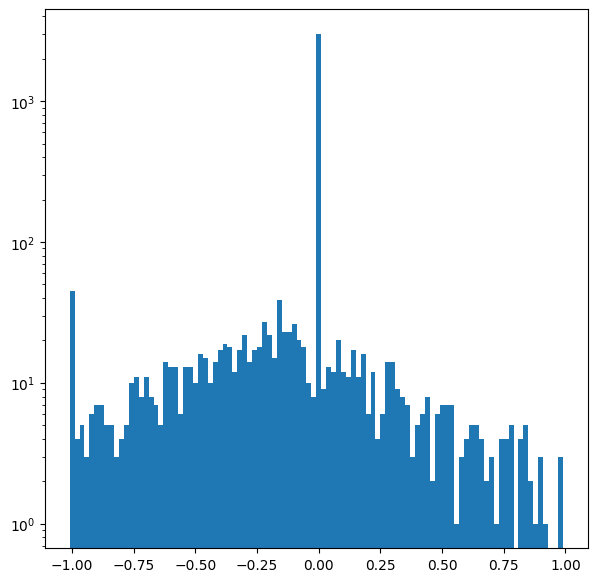

In [15]:
# Analyze training result
w = model.layers[8].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))




print_qstats(model)

In [124]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 26, 26, 16)        160       
                                                                 
 q_relu (QActivation)        (None, 26, 26, 16)        0         
                                                                 
 maxp (MaxPooling2D)         (None, 13, 13, 16)        0         
                                                                 
 q_conv2d_1 (QConv2D)        (None, 11, 11, 16)        2320      
                                                                 
 1_relu_1 (QActivation)      (None, 11, 11, 16)        0         
                                                                 
 maxp_1 (MaxPooling2D)       (None, 5, 5, 16)          0     

In [21]:
#hls4ml config

In [16]:
import hls4ml
from utils import plotting
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

Trace = True

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

#config['Backend'] = 'vivado_accelerator'

config['Model'] = {}
config['Model']['ReuseFactor'] = 36
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<10,6>'

config['LayerName']['layer0']['Precision'] = 'ap_ufixed<8,3>'

config['LayerName']['q_conv2d']['ReuseFactor'] = 72
#config['LayerName']['q_conv2d']['Precision']['weight']   = 'ap_fixed<2,1>'
#config['LayerName']['q_conv2d']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_conv2d']['Precision']['result']   = 'ap_fixed<9,3>'
config['LayerName']['q_conv2d']['Trace']       = Trace
config['LayerName']['q_conv2d']['Strategy'] = 'Latency'

config['LayerName']['maxp']['Precision']   = 'ap_fixed<3,2>'
config['LayerName']['maxp']['Trace']       = Trace

config['LayerName']['q_conv2d_1']['ReuseFactor'] = 72
#config['LayerName']['q_conv2d_1']['Precision']['weight']   = 'ap_fixed<3,1>'
#config['LayerName']['q_conv2d_1']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_conv2d_1']['Precision']['result']   = 'ap_fixed<9,5>'
config['LayerName']['q_conv2d_1']['Trace']       = Trace
config['LayerName']['q_conv2d_1']['Strategy'] = 'Latency'

config['LayerName']['maxp_1']['Precision']   = 'ap_fixed<3,2>'
config['LayerName']['maxp_1']['Trace']       = Trace

config['LayerName']['q_dense']['ReuseFactor'] = 20
#config['LayerName']['q_dense']['Precision']['weight']   = 'ap_fixed<3,1>'
#config['LayerName']['q_dense']['Precision']['bias']     = 'ap_fixed<11,3>'
config['LayerName']['q_dense']['Precision']['result']   = 'ap_fixed<10,6>'
config['LayerName']['q_dense']['Trace']       = Trace
config['LayerName']['q_dense']['Strategy'] = 'Resource'


config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<12,4>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<12,2>'
config['LayerName']['softmax']['table_size']  = 256
config['LayerName']['softmax']['Precision']   = 'ap_fixed<8,2>'
config['LayerName']['softmax']['Strategy']    = 'Stable'
config['LayerName']['softmax']['Trace']       = Trace


config['SkipOptimizers'] = ['reshape_stream']
#config['Optimizers']     = ['eliminate_linear_activation']

cfg = hls4ml.converters.create_config(part='xc7z020clg400-1', backend='VivadoAccelerator')
cfg['HLSConfig'] = config

cfg['AcceleratorConfig']['Driver']    = 'python'
cfg['AcceleratorConfig']['Board']     = 'pynq-z2'
cfg['AcceleratorConfig']['Interface'] = 'axi_stream'
#cfg['AcceleratorConfig']['Interface'] = 'axi_lite'
#cfg['AcceleratorConfig']['Interface'] = 'axi_master'
cfg['AcceleratorConfig']['Precision']['Input']  = 'ap_fixed<8,2>'
cfg['AcceleratorConfig']['Precision']['Output'] = 'ap_fixed<8,2>'

cfg['IOType']= 'io_stream'
cfg['KerasModel'] = model
cfg['OutputDir'] = PROJECT_PATH + 'Qkeras_pruned_CNN/hls4ml_PYNQ_prj'

print("-----------------------------------")
plotting.print_dict(cfg)
print("-----------------------------------")
hls_model = hls4ml.converters.keras_to_hls(cfg)
#hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=x_test[:1000])


#print("-----------------------------------")
#plotting.print_dict(config)
#print("-----------------------------------")
#hls_model = hls4ml.converters.convert_from_keras_model(model,
#                                                       hls_config=config,
#                                                       output_dir='model_3/hls4ml_prj',

Interpreting Model
Topology:
Layer name: layer0, layer type: Input
Layer name: q_conv2d, layer type: QConv2D
Layer name: q_relu, layer type: QActivation
Layer name: maxp, layer type: MaxPooling2D
Layer name: q_conv2d_1, layer type: QConv2D
Layer name: 1_relu_1, layer type: QActivation
Layer name: maxp_1, layer type: MaxPooling2D
Layer name: q_dense, layer type: QDense
Layer name: softmax, layer type: Activation
-----------------------------------
OutputDir:           /content/drive/MyDrive/PYNQ_IA/NN_train/MNIST_Test/HLS_projects/Qkeras_pruned_CNN/hls4ml_PYNQ_prj
ProjectName:         myproject
Backend:             VivadoAccelerator
XilinxPart:          xc7z020clg400-1
Board:               pynq-z2
ClockPeriod:         5
IOType:              io_stream
HLSConfig
  Model
    ReuseFactor:     36
    Strategy:        Resource
    Precision:       ap_fixed<10,6>
  LayerName
    layer0
      Precision:     ap_ufixed<8,3>
    q_conv2d
      Precision
        weight:      ap_fixed<4,2>
        b

/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [17]:
hls_model.compile()

Writing HLS project


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [18]:
with tf.device('/cpu:0'):
    y_qkeras = model.predict((x_test))
y_hls = hls_model.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 3s 7ms/step


Accuracy pruned, quantized: 0.9793
Accuracy hls4ml: 0.9699


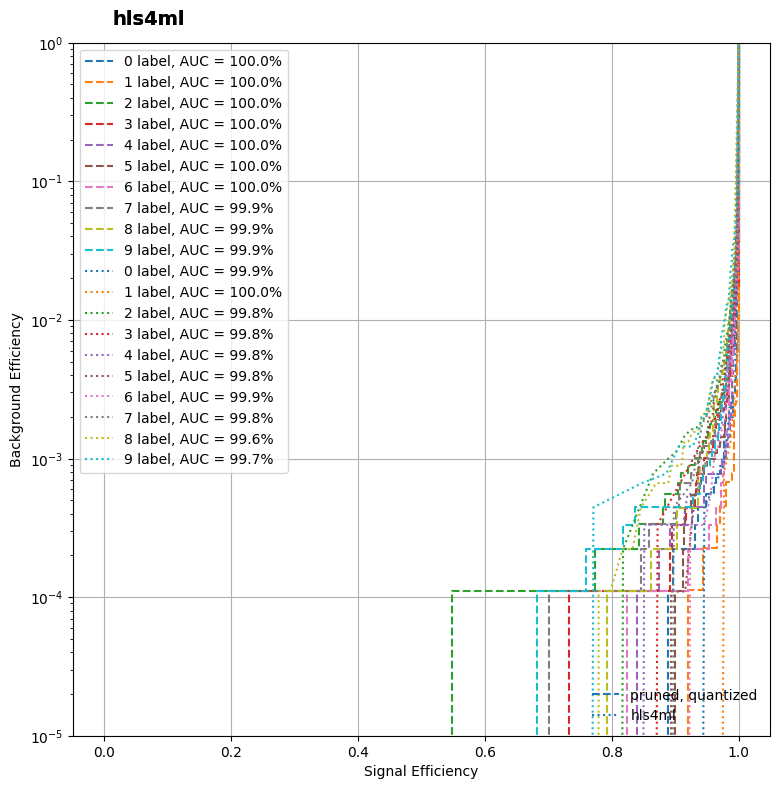

In [19]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model(MODEL_PATH + 'Keras_only/KERAS_check_best_model.h5')
#with tf.device('/cpu:0'):
#    y_ref = model_ref.predict(X_test)

#print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_ref, classes)
#plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle='--')
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls   , ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], linestyle=':')

from matplotlib.lines import Line2D
lines = [#Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['pruned, quantized', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

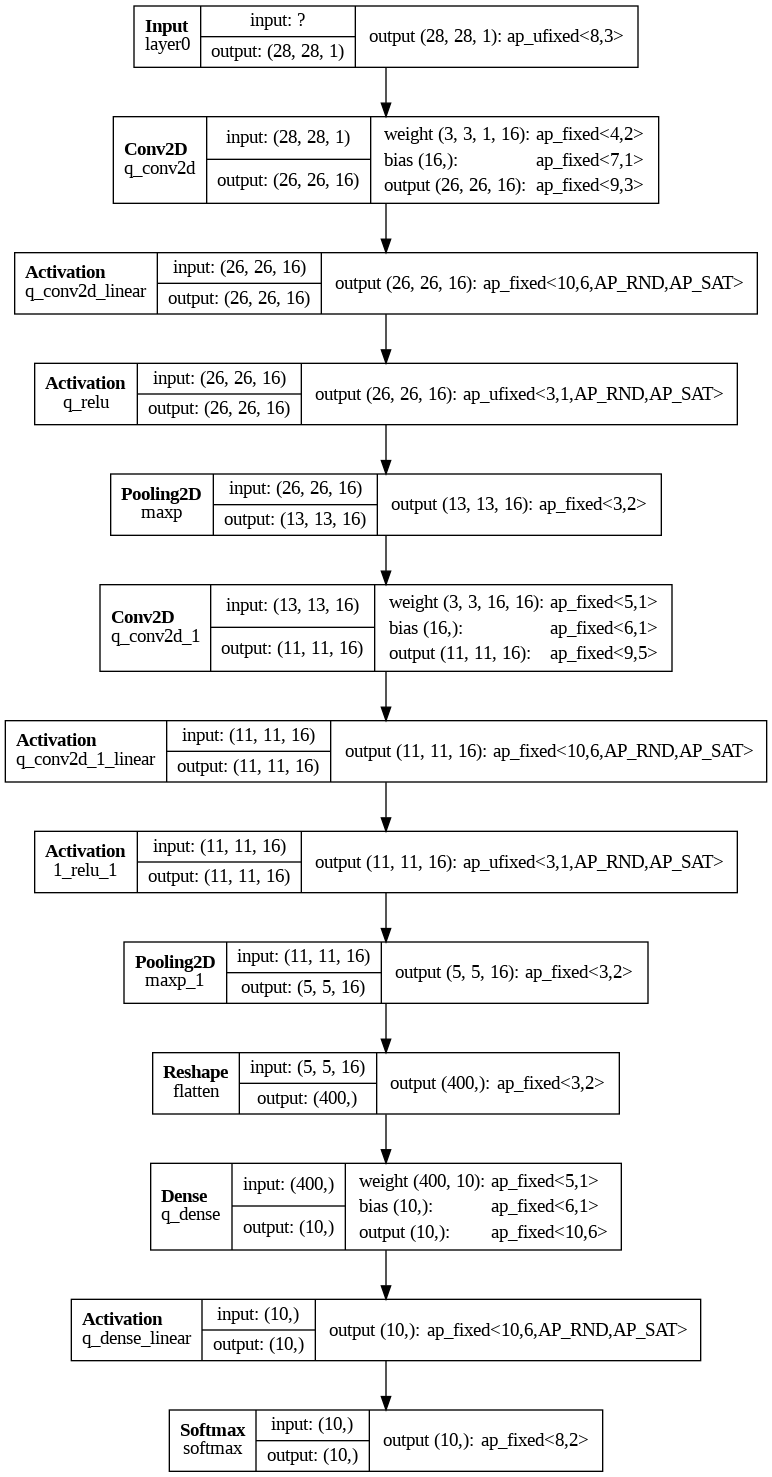

In [20]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Now we can do the Reverse Engineering Step

Step 1: Probing using some training data and get the output as the labels of these training data.



In [ ]:
## Assume We have a lot of  data without labels.
# We can use the model to generate labels for these data, and retrain a model on it

In [27]:
print(y_test,y_qkeras)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[9.7755937e-08 1.8763886e-09 5.9202794e-05 ... 9.9983311e-01
  2.6572818e-07 4.9361893e-06]
 [1.0545131e-04 1.1999549e-02 9.8350137e-01 ... 2.0356890e-07
  5.0885828e-06 1.9343176e-09]
 [6.1743367e-07 9.9918109e-01 7.1774293e-06 ... 9.9081357e-05
  7.2904577e-06 2.1889925e-06]
 ...
 [1.6988272e-08 1.0510272e-06 2.0609112e-09 ... 1.7776778e-05
  3.8226077e-05 6.0138063e-05]
 [2.6925863e-05 2.4034912e-07 4.8551857e-07 ... 3.4232391e-06
  5.7242238e-03 1.5254541e-04]
 [9.2232503e-06 3.8948417e-11 1.4285250e-05 ... 2.9988616e-09
  1.3081350e-06 4.2712120e-08]]


In [23]:
#reverse y_qkeras to 1-hot coding
y_pred_indices = np.argmax(y_qkeras, axis=1)

y_qkeras_one_hot = np.zeros_like(y_qkeras)
y_qkeras_one_hot[np.arange(len(y_qkeras)), y_pred_indices] = 1

In [21]:
## Generate labels for reverse engineering
with tf.device('/cpu:0'):
    y_qkeras_train = model.predict((x_train))
y_hls_train = hls_model.predict(np.ascontiguousarray(x_train))

In [26]:
#reverse y_qkeras_train to 1-hot coding
y_train_pred_indices = np.argmax(y_qkeras_train, axis=1)

y_qkeras_train_one_hot = np.zeros_like(y_qkeras_train)
y_qkeras_train_one_hot[np.arange(len(y_qkeras_train)), y_train_pred_indices] = 1

In [28]:
file_path = 'y_qkeras_train_one_hot.csv'

# Save the array to a CSV file
np.savetxt(file_path, y_qkeras_train_one_hot, delimiter=',')

In [30]:
file_path = 'y_hls_train.csv'

# Save the array to a CSV file
np.savetxt(file_path, y_hls_train, delimiter=',')

In [24]:
print(y_test[:5])
print(y_qkeras_one_hot[:5])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [70]:
# Retrain a model on the y_qkeras_train_one_hot
# 1st assume we also know the models shape
reversed_model = get_cnn_qmodel()
reversed_model=prune.prune_low_magnitude(reversed_model, **pruning_params)
adam = Adam(lr=0.0001)
reversed_model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
callbacks = all_callbacks(stop_patience = 1000,
                          lr_factor     = 0.5,
                          lr_patience   = 20,
                          lr_epsilon    = 0.000001,
                          lr_cooldown   = 5,
                          lr_minimum    = 0.000001,
                          verbose       = False,
                          outputDir = MODEL_PATH + 'Qkeras_pruned_CNN')
callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
with tf.device('/gpu:0'):
    reversed_model.fit(x_train, y_qkeras_train_one_hot, batch_size=10,
              epochs=1, validation_split=0.25, shuffle=True,
              verbose = 1,
              callbacks = callbacks.callbacks)
with tf.device('/cpu:0'):
# Save the model again but with the pruning 'stripped' to use the regular layer types
    reversed_model = strip_pruning(reversed_model)
    reversed_model.save( MODEL_PATH + 'Qkeras_pruned_CNN/Reversed_QKERAS_check_best_model.h5')


Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_conv2d_1                    : 278784 (smult_5_3)
    q_dense                       : 4000  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 282784

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_conv2d_1_weights             : 2304  (5-bit unit)
    q_conv2d_1_bias                : 16    (6-bit unit)
    q_dense_weights                : 4000  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.2250
    q_conv2d_1                     : 0.1866
    q_dense                        : 0.3302
    ----------------------------------------
    Total Sparsity                 : 0.2763


   1/4500 [..............................] - ETA: 4:38:14 - loss: 3.1833 - accuracy: 0.1000

4496/4500 [============================>.] - ETA: 0s - loss: 0.3796 - accuracy: 0.8964

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4500/4500 [==============================] - 49s 10ms/step - loss: 0.3795 - accuracy: 0.8964 - val_loss: 0.1766 - val_accuracy: 0.9464 - lr: 0.0010


In [71]:

with tf.device('/cpu:0'):
    y_reversed_test =  reversed_model.predict((x_test))

313/313 [==============================] - 3s 8ms/step


In [72]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

print("Accuracy of reversed_model: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_reversed_test, axis=1))))



Accuracy of reversed_model: 0.9453


% of zeros = 0.75


/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(



Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_conv2d_1                    : 278784 (smult_5_3)
    q_dense                       : 4000  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 282784

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_conv2d_1_weights             : 2304  (5-bit unit)
    q_conv2d_1_bias                : 16    (6-bit unit)
    q_dense_weights                : 4000  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.6937
    q_conv2d_1                     : 0.7578
    q_dense                        : 0.7611
    ----------------------------------------
    Total Sparsity                 : 0.7582


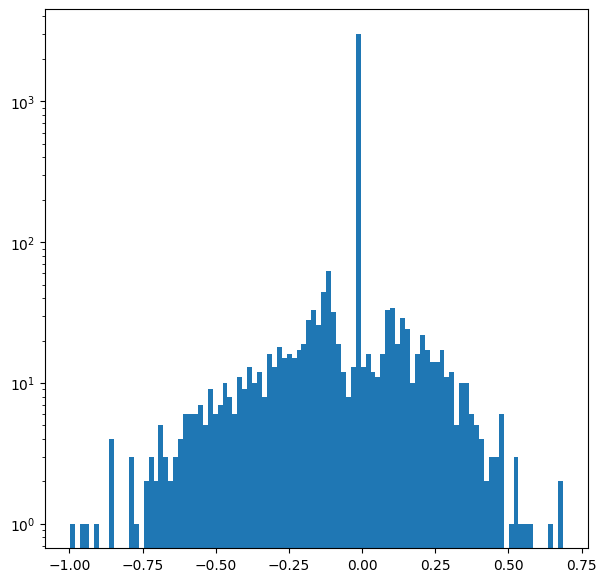

In [73]:
# Analyze training result
w = reversed_model.layers[8].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7,7))
plt.bar(b[:-1], h, width=b[1]-b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))




print_qstats(reversed_model)

In [123]:
reversed_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 26, 26, 16)        160       
                                                                 
 q_relu (QActivation)        (None, 26, 26, 16)        0         
                                                                 
 maxp (MaxPooling2D)         (None, 13, 13, 16)        0         
                                                                 
 q_conv2d_1 (QConv2D)        (None, 11, 11, 16)        2320      
                                                                 
 1_relu_1 (QActivation)      (None, 11, 11, 16)        0         
                                                                 
 maxp_1 (MaxPooling2D)       (None, 5, 5, 16)          0  

In [74]:
def get_simple_cnn_qmodel():
    x = x_in = Input((28,28,1), name="layer0")
    x = QConv2D(
        16, (3, 3),
        kernel_quantizer=quantized_bits(4,1,0,alpha=1),
        bias_quantizer=quantized_bits(7,0,0,alpha=1),
        name="q_conv2d")(x)
    x = QActivation("quantized_relu(3,1)", name="q_relu")(x)
    x = MaxPooling2D((2,2), name='maxp')(x)
    x = MaxPooling2D((2,2), name='maxp_1')(x)
    x = Flatten()(x)
    x = QDense(10, name='q_dense',
              kernel_quantizer=quantized_bits(5,0,0,alpha=1),
              #kernel_quantizer="stochastic_ternary()",
              bias_quantizer=quantized_bits(6,0,0,alpha=1))(x)
    x = Activation("softmax", name='softmax')(x)

    model = Model(inputs=x_in, outputs=x)

    print_qstats(model)

    return model

In [77]:
# Retrain a model on the y_qkeras_train_one_hot
# 1st assume we also know the models shape
reversed_simple_model = get_simple_cnn_qmodel()
reversed_simple_model=prune.prune_low_magnitude(reversed_simple_model, **pruning_params)
adam = Adam(lr=0.0001)
reversed_simple_model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
callbacks = all_callbacks(stop_patience = 1000,
                          lr_factor     = 0.5,
                          lr_patience   = 20,
                          lr_epsilon    = 0.000001,
                          lr_cooldown   = 5,
                          lr_minimum    = 0.000001,
                          verbose       = False,
                          outputDir = MODEL_PATH + 'Qkeras_pruned_CNN')
callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
with tf.device('/gpu:0'):
    reversed_simple_model.fit(x_train, y_qkeras_train_one_hot, batch_size=10,
              epochs=1, validation_split=0.25, shuffle=True,
              verbose = 1,
              callbacks = callbacks.callbacks)
with tf.device('/cpu:0'):
# Save the model again but with the pruning 'stripped' to use the regular layer types
    reversed_simple_model = strip_pruning(reversed_simple_model)
    reversed_simple_model.save( MODEL_PATH + 'Qkeras_pruned_CNN/Reversed_Simple_QKERAS_check_best_model.h5')


Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_dense                       : 5760  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 5760

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_dense_weights                : 5760  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.2188
    q_dense                        : 0.3851
    ----------------------------------------
    Total Sparsity                 : 0.3806
   1/4500 [..............................] - ETA: 2:31:39 - loss: 2.6430 - accuracy: 0.1000

4500/4500 [==============================] - 40s 8ms/step - loss: 0.4861 - accuracy: 0.8564 - val_loss: 0.3140 - val_accuracy: 0.9045 - lr: 0.0010


In [81]:

with tf.device('/cpu:0'):
    y_reversed_test =  reversed_simple_model.predict((x_test))

313/313 [==============================] - 4s 10ms/step


In [82]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

print("Accuracy of reversed_model: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_reversed_test, axis=1))))

Accuracy of reversed_model: 0.9016


In [86]:
# Analyze training result

print_qstats(reversed_simple_model)

/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(



Number of operations in model:
    q_conv2d                      : 97344 (smult_4_8)
    q_dense                       : 5760  (smult_5_3)

Number of operation types in model:
    smult_4_8                     : 97344
    smult_5_3                     : 5760

Weight profiling:
    q_conv2d_weights               : 144   (4-bit unit)
    q_conv2d_bias                  : 16    (7-bit unit)
    q_dense_weights                : 5760  (5-bit unit)
    q_dense_bias                   : 10    (6-bit unit)

Weight sparsity:
... quantizing model
    q_conv2d                       : 0.7063
    q_dense                        : 0.7655
    ----------------------------------------
    Total Sparsity                 : 0.7639


In [122]:
reversed_simple_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 q_conv2d (QConv2D)          (None, 26, 26, 16)        160       
                                                                 
 q_relu (QActivation)        (None, 26, 26, 16)        0         
                                                                 
 maxp (MaxPooling2D)         (None, 13, 13, 16)        0         
                                                                 
 maxp_1 (MaxPooling2D)       (None, 6, 6, 16)          0         
                                                                 
 flatten_16 (Flatten)        (None, 576)               0         
                                                                 
 q_dense (QDense)            (None, 10)                577

In [97]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def get_resnet50_mnist():
    # Input layer that accepts grayscale images of size 28x28
    input_tensor = Input(shape=(28, 28, 1))

    # Use a resizing layer to upscale to closer to expected ResNet input size
    resized_input = Resizing(224, 224, interpolation="bilinear")(input_tensor)

    # Convert grayscale to 3-channel
    x = Conv2D(3, (3, 3), padding='same')(resized_input)  # Convert to 3 channels

    # Load ResNet50 without top layers and without weights initially
    base_model = ResNet50(weights=None, include_top=False, input_tensor=x)

    # Add new layers on top of ResNet
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Adding global average pooling layer
    x = Dense(1024, activation='relu')(x)  # Additional dense layer
    x = Dense(10, activation='softmax')(x)  # Output layer for 10 classes

    # Create the complete model
    model = Model(inputs=input_tensor, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print the model summary
    model.summary()

    return model

# Create the model for MNIST
resnet50_mnist = get_resnet50_mnist()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 resizing_4 (Resizing)       (None, 224, 224, 1)          0         ['input_32[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 224, 224, 3)          30        ['resizing_4[0][0]']          
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['conv2d_7[0][0]']            
                                                                                           

In [104]:
# Retrain a model on the y_qkeras_train_one_hot
# 1st assume we also know the models shape

adam = Adam(lr=0.0001)
resnet50_mnist.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
callbacks = all_callbacks(stop_patience = 1000,
                          lr_factor     = 0.5,
                          lr_patience   = 20,
                          lr_epsilon    = 0.000001,
                          lr_cooldown   = 5,
                          lr_minimum    = 0.000001,
                          verbose       = False,
                          outputDir = MODEL_PATH + 'Qkeras_pruned_CNN')
callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
with tf.device('/gpu:0'):
    resnet50_mnist.fit(x_train, y_qkeras_train_one_hot, batch_size=100,
              epochs=1, validation_split=0.25, shuffle=True,
              verbose = 1,
              callbacks = callbacks.callbacks)
with tf.device('/cpu:0'):
# Save the model again but with the pruning 'stripped' to use the regular layer types
    resnet50_mnist.save( MODEL_PATH + 'Qkeras_pruned_CNN/Reversed_RESNET50_QKERAS_check_best_model.h5')

  6/450 [..............................] - ETA: 7:13 - loss: 8.0098 - accuracy: 0.1233

450/450 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8821

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


450/450 [==============================] - 540s 1s/step - loss: 0.4455 - accuracy: 0.8821 - val_loss: 4.9518 - val_accuracy: 0.3164 - lr: 0.0010


In [106]:

with tf.device('/cpu:0'):
    y_reversed_test =  resnet50_mnist.predict((x_test))

313/313 [==============================] - 1643s 5s/step


In [107]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

print("Accuracy of reversed_model: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_reversed_test, axis=1))))

Accuracy of reversed_model: 0.305


In [127]:


def print_weight_density(model, threshold=1e-3):
    total_weights = 0
    nonzero_weights = 0

    for weight in model.trainable_weights:
        # Get the numpy array of the weight values
        weight_array = weight.numpy()
        # Flatten the array to iterate over it
        flat_weights = weight_array.flatten()
        total_weights += flat_weights.size
        # Count weights that are above the threshold (not considered zero)
        nonzero_weights += np.sum(np.abs(flat_weights) > threshold)

    density = nonzero_weights / total_weights
    print(f"Weight Density: {density * 100:.2f}%")

print_weight_density(resnet50_mnist)


Weight Density: 97.35%


In [129]:
print(resnet50_mnist.summary())

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       multiple                     0         []                            
                                                                                                  
 resizing_4 (Resizing)       (None, 224, 224, 1)          0         ['input_32[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 224, 224, 3)          30        ['resizing_4[0][0]']          
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['conv2d_7[0][0]']            
                                                                                           